In [16]:
#pip install pandas numpy statsmodels matplotlib

## libreria

In [17]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os



## carga bd

In [18]:
# 1. Load the dataset
# Using relative path as requested
file_path = "input/bacon_example.csv" 
df = pd.read_csv(file_path)

# Preview data to understand structure (check for treatment time variable)
print(df.head())
print(df.columns)
output_path = "output_python"

   stfips  year    _nfd  post      asmrs         pcinc     asmrh     cases  \
0       1  1964  1971.0     0  35.639885  12406.178537  5.007341  0.012312   
1       1  1965  1971.0     0  41.543755  13070.206738  4.425367  0.010419   
2       1  1966  1971.0     0  34.252335  13526.663217  4.874819  0.009900   
3       1  1967  1971.0     0  34.465023  13918.189823  5.362014  0.009975   
4       1  1968  1971.0     0  40.440105  14684.808682  4.643759  0.012401   

      weight         copop  
0  1715156.0  1.715156e+06  
1  1715156.0  1.725186e+06  
2  1715156.0  1.735219e+06  
3  1715156.0  1.745250e+06  
4  1715156.0  1.755283e+06  
Index(['stfips', 'year', '_nfd', 'post', 'asmrs', 'pcinc', 'asmrh', 'cases',
       'weight', 'copop'],
      dtype='object')


## parte a

In [19]:
# --- Part A: TWFE Regression ---

# We use C(stfips) for Unit Fixed Effects and C(year) for Time Fixed Effects
# We interpret the coefficient on 'post' (the treatment dummy)
formula_twfe = 'asmrs ~ post + pcinc + asmrh + cases + C(stfips) + C(year)'

# Fit the model
model_twfe = smf.ols(formula_twfe, data=df).fit()

# Calculate Clustered Standard Errors (Cluster by State)
# It is standard practice in DiD to cluster by the unit level
twfe_results = model_twfe.get_robustcov_results(cov_type='cluster', groups=df['stfips'])



In [20]:
# --- Part B: Cleaning for Event-Study ---

# 1. Create relative time variable
# Note: Treat missing _nfd (never treated) carefully. 
# If _nfd is NaN, relative time should handle it (usually drop from event study dummies or treat as control)
# In this dataset, never-treated might be coded differently, let's assume valid years.
df['event_time'] = df['year'] - df['_nfd']

# Handle never-treated units (if _nfd is missing or 0)
# We usually set their event_time to something that won't trigger the dummies
df['event_time'] = df['event_time'].fillna(-999) 

# 2. Descriptive summary
print("\nEvent Time Frequency (Head and Tail):")
print(df['event_time'].value_counts().sort_index().iloc[::5]) # Printing every 5th for brevity

# 3. Binning (Grouping extreme values)
# Let's observe the distribution. Often ranges like [-8, 8] or [-10, 10] are used.
# Let's pick lower bound = -8 and upper bound = 10 for this example.
lower_bound = -8
upper_bound = 10

# Create a new column for the binned time
df['rel_time_binned'] = df['event_time']

# Clip values at the bounds
df.loc[df['event_time'] < lower_bound, 'rel_time_binned'] = lower_bound
df.loc[df['event_time'] > upper_bound, 'rel_time_binned'] = upper_bound

# 4. Create relative-time dummy variables
# We need to treat 'rel_time_binned' as categorical
# We create a dummy for every unique value in the binned range
# Note: We do NOT create dummies for the Never Treated (represented by NaN or -999 in raw calculation)

# Generate list of sorted relative times within bounds
rel_times = sorted([k for k in df['rel_time_binned'].unique() 
                    if k >= lower_bound and k <= upper_bound])

# Create binary columns manually to have full control
# Format: "lead_2" for -2, "lag_2" for +2, etc.
dummies_list = []
for k in rel_times:
    col_name = f"rel_{int(k)}".replace("-", "neg") # e.g., rel_neg2, rel_0, rel_5
    df[col_name] = (df['rel_time_binned'] == k).astype(int)
    dummies_list.append(col_name)

# Identify the reference category (usually t = -1)
# We must DROP this from the regression to avoid multicollinearity
ref_category = "rel_neg1"
if ref_category in dummies_list:
    dummies_list.remove(ref_category)

print(f"\nRelative time dummies created: {dummies_list}")


Event Time Frequency (Head and Tail):
event_time
-999.0    429
-17.0       2
-12.0       7
-7.0       32
-2.0       36
 3.0       36
 8.0       36
 13.0      34
 18.0      33
 23.0      24
Name: count, dtype: int64

Relative time dummies created: ['rel_neg8', 'rel_neg7', 'rel_neg6', 'rel_neg5', 'rel_neg4', 'rel_neg3', 'rel_neg2', 'rel_0', 'rel_1', 'rel_2', 'rel_3', 'rel_4', 'rel_5', 'rel_6', 'rel_7', 'rel_8', 'rel_9', 'rel_10']


Estimando modelo... esto puede tardar unos segundos.
Tabla de coeficientes guardada en: output_python\event_study_coefs.csv
Gráfico guardado en: output_python\event_study_plot.png


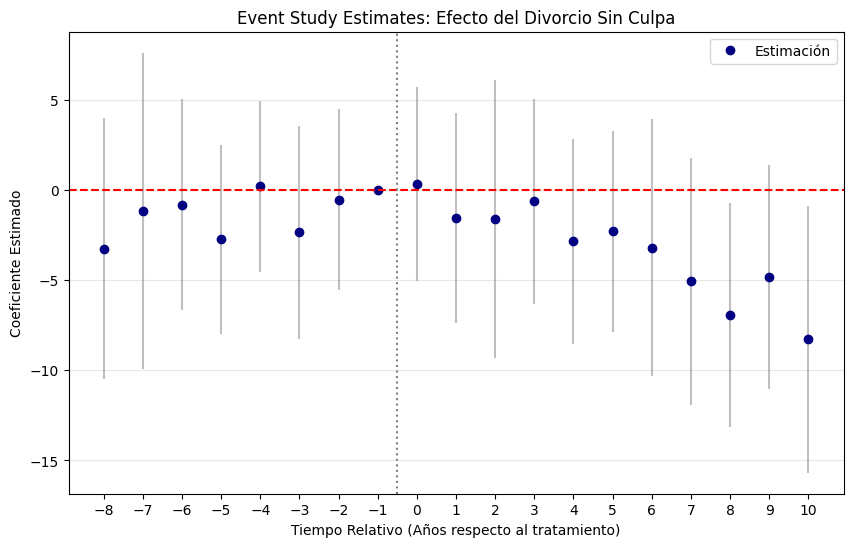

In [21]:
# 1. Estimar el modelo base
# Asumimos que 'dummies_list' y 'rel_times' vienen de la Parte B
# Construimos la fórmula: Outcome ~ Dummies + Controls + FEs
dummy_formula = " + ".join(dummies_list)

# Nota: C(stfips) y C(year) son efectos fijos de estado y año
formula_es = f"asmrs ~ {dummy_formula} + pcinc + asmrh + cases + C(stfips) + C(year)"

print("Estimando modelo... esto puede tardar unos segundos.")
model_es = smf.ols(formula_es, data=df).fit()

# 2. Calcular Errores Robustos (Clusterizados)
# Clusterizamos por 'stfips' (estado)
es_results = model_es.get_robustcov_results(cov_type='cluster', groups=df['stfips'])

# Convertimos params y bse a Series para facilitar la búsqueda por nombre
params_series = pd.Series(es_results.params, index=es_results.model.exog_names)
bse_series = pd.Series(es_results.bse, index=es_results.model.exog_names)

# 3. Almacenar coeficientes
coefs = []
bse = []
periods = []

# Definimos la categoría de referencia (asumimos t = -1 si no está definida)
# Asegúrate de que coincida con lo que excluiste en la Parte B
if 'ref_category' not in locals():
    ref_category = "rel_neg1" 

for k in rel_times:
    # Reconstruir nombre de la variable: e.g., -2 -> "rel_neg2", 0 -> "rel_0"
    suffix = str(int(k)).replace("-", "neg")
    col_name = f"rel_{suffix}"
    
    # Manejo de la categoría base (t=-1)
    if col_name == ref_category:
        coefs.append(0)
        bse.append(0)
    else:
        try:
            coefs.append(params_series[col_name])
            bse.append(bse_series[col_name])
        except KeyError:
            # Si no encuentra la variable, advertimos y ponemos NaN
            print(f"Advertencia: Variable {col_name} no encontrada.")
            coefs.append(np.nan)
            bse.append(np.nan)
    
    periods.append(k)

# 4. Crear DataFrame para resultados
res_df = pd.DataFrame({'period': periods, 'coef': coefs, 'se': bse})

# Calcular Intervalos de Confianza (95%)
res_df['ci_lower'] = res_df['coef'] - 1.96 * res_df['se']
res_df['ci_upper'] = res_df['coef'] + 1.96 * res_df['se']

# --- GUARDAR CSV (Resultados numéricos) ---
csv_filename = os.path.join(output_path, "event_study_coefs.csv")
res_df.to_csv(csv_filename, index=False)
print(f"Tabla de coeficientes guardada en: {csv_filename}")

# 5. Graficar y Guardar
plt.figure(figsize=(10, 6))

# Líneas de IC
plt.vlines(x=res_df['period'], ymin=res_df['ci_lower'], ymax=res_df['ci_upper'], color='grey', alpha=0.5)

# Puntos de coeficientes
plt.plot(res_df['period'], res_df['coef'], 'o', color='navy', label='Estimación')

# Línea base y momento del tratamiento
plt.axhline(y=0, color='red', linestyle='--')
plt.axvline(x=-0.5, color='grey', linestyle=':')

# Etiquetas
plt.title('Event Study Estimates: Efecto del Divorcio Sin Culpa')
plt.xlabel('Tiempo Relativo (Años respecto al tratamiento)')
plt.ylabel('Coeficiente Estimado')
plt.xticks(sorted(periods)) # Mostrar todos los ticks del eje X
plt.grid(True, axis='y', alpha=0.3)
plt.legend()

# --- GUARDAR PLOT (Imagen) ---
plot_filename = os.path.join(output_path, "event_study_plot.png")
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Gráfico guardado en: {plot_filename}")

# Mostrar gráfico final
plt.show()